# SurvSHAP vs DeepLift vs Integrated Gradients
### J. Krajewski, S. Frejlak, M. Wojtala

### Notebook description

This notebook contains experiments aiming at establishing the quality of gradient-based methods for deep survival models and comparing their explanations with those prvovided by SurvSHAP.

#### Data

We take datasets containing time-dependent data from the original SurvSHAP repository. The first dataset on which we run experiments, `exp1_data_complex.csv`,  is artificial. Dependence of the `event` variable on explanatory variable `x1` changes through time. Dependence on the variables `x2`, `x3` and `x4` doesn't change through time. The last explanatory variable `x5` is just noise, and the explained variable doesn't depend on it. The dataset contains 1000 examples.

The second dataset on which we run experiments, `exp3_heart_failure_dataset.csv`, contains medical data. There are eleven explanatory variables and the survival model is trained to predict `DEATH_EVENT` after a given period of time passes.

#### Deep survival model

As a deep survival model, we use `DeepHitSingle` from the `pycox` library. It's an implementation of the DeepHit method for a single event, as opposed to competing risks. The method is described in this paper: https://ojs.aaai.org/index.php/AAAI/article/view/11842

#### Explanation methods

As a gradient-based explanation method, we use `IntegratedGradients` from the `captum` library. It's an implementation of the method described in this paper: https://arxiv.org/abs/1703.01365

We compare the attributions obtained by Integrated Gradient with SurvSHAP attributions. SurvSHAP is a model-agnostic explanation method designed specifically for survival models. It is described in this paper: https://arxiv.org/abs/2208.11080

#### Used metrics

We measure the accuracy of Integrated Gradients attributions using Brier score. We further use metrics of Average Sensitivity and Faithfulness Correlation, taking their implemations from the `quantus` library. Both of these metrics are defined in this paper: https://arxiv.org/abs/2005.00631

### Imports

In [1]:
# This code is useful if you want to make changes in any of the imported libraries, e.g. to solve compatibility issues.
%load_ext autoreload
%autoreload 2

In [2]:
!pip3 install torchtuples
!pip3 install pycox

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from scipy.integrate import trapezoid
from typing import List
from datetime import datetime
import os
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sksurv.functions import StepFunction

import torch  # For building the networks
import torchtuples as tt  # Some useful functions

from pycox.models import DeepHitSingle

from survshap import SurvivalModelExplainer, ModelSurvSHAP, PredictSurvSHAP
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
)

import quantus

from pycox.evaluation import EvalSurv
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "jpeg"

# os.environ["CUDA_VISIBLE_DEVICES"]=""

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Helper classes and functions

#### Data preprocessing

In [3]:
class ColumnNotPresentError(Exception):
    def __init__(self, ke, column_name_parameter, column_names):
        self.message = f"'{ke.__str__}' not present in dataframe columns. Please, specify the correct column name(s) as parameter(s) {column_name_parameter}. Available options: {', '.join(list(column_names))}"
        super().__init__(self.message)


def train_val_test_split(dataframe_raw, verbose=True, time_column="time"):
    dataframe_test = dataframe_raw.sample(frac=0.2, random_state=8)
    dataframe_train = dataframe_raw.drop(dataframe_test.index)
    dataframe_val = dataframe_train.sample(frac=0.2, random_state=8)
    dataframe_train = dataframe_train.drop(dataframe_val.index)
    if verbose:
        print(dataframe_raw.head())
        try:
            print(
                f"Min time: {dataframe_raw[time_column].min():.4g} Max time: {dataframe_raw[time_column].max():.4g} Average time: {dataframe_raw[time_column].mean():.4g}"
            )
        except KeyError as ke:
            raise ColumnNotPresentError(ke, "time_column", dataframe_raw.columns)
    return dataframe_train, dataframe_test, dataframe_val


def standardize_mapper(to_standardize, to_leave):
    standardize = [([col], StandardScaler()) for col in to_standardize]
    leave = [(col, None) for col in to_leave]

    return DataFrameMapper(leave + standardize)

In [4]:
def prepare_x_y(
    dataframe_split: List[pd.DataFrame],
    to_standardize,
    to_leave,
    num_durations,
    time_column="time",
    event_column="event",
):
    """Provide a dataframe with the training set as the first one in the list dataframe_split"""
    x_mapper = standardize_mapper(to_standardize, to_leave)
    label_transform = DeepHitSingle.label_transform(num_durations)
    df_first = dataframe_split[0]

    try:
        get_target = lambda df: (df[time_column].values, df[event_column].values)

        x_list = [x_mapper.fit_transform(df_first).astype("float32")]
        y_list = [label_transform.fit_transform(*get_target(df_first))]
        for df_next in dataframe_split[1:]:
            x_list.append(x_mapper.transform(df_next).astype("float32"))
            y_list.append(label_transform.transform(*get_target(df_next)))
    except KeyError as ke:
        raise ColumnNotPresentError(ke, "time_column, event_column", df_first.columns)
    return zip(x_list, y_list), label_transform

### Helper classes for unifying the worlds of SurvSHAP and captum

In [5]:
class DeepHitSingle_(DeepHitSingle):
    """Extension of the DeepHitSingle class from pycox to make it compatible with SurvShap and IG"""

    def predict_survival_function(self, X):
        X = torch.tensor(np.asarray(X), dtype=torch.float32).to(DEVICE)

        surv_df = self.predict_surv_df(X, batch_size=128).astype("float32")
        event_times_ = surv_df.index.values
        sf_values = surv_df.T.values

        return np.array([StepFunction(event_times_, values) for values in sf_values])

    def plot_survival_function(self, observation_number: int):
        new_observation = pd.DataFrame(
            np.atleast_2d(self.x_val[observation_number]),
            columns=[f"var_{i}" for i in range(self.x_val.shape[1])],
        )

        return px.line(
            x=self.predict_survival_function(new_observation)[0].x,
            y=self.predict_survival_function(new_observation)[0].y,
        )

    # Should be not necessary in our case
    def predict_cumulative_hazard_function(self, X):
        X = torch.tensor(np.asarray(X), dtype=torch.float32).to(DEVICE)

        pmf = self.predict_pmf(X, numpy=True, to_cpu=True).astype("float32")
        # event_times_ = list(range(pmf.shape[1]))
        surv_df = self.predict_surv_df(X, batch_size=128).astype("float32")
        event_times_ = surv_df.index.values

        return np.array([StepFunction(event_times_, p) for p in pmf])

    def fit(self, *args, **kwargs):
        self.x_val, self.y_val = kwargs["val_data"]
        return super().fit(*args, **kwargs)

#### Computation and visualization of attributions and metrics

In [6]:
def compute_attributions(model, inputs, outputs, num_durations, all_input, columns):
    num_examples = inputs.shape[0]
    num_features = inputs.shape[1]
    aggregated_attributions = np.empty([num_examples, num_durations, num_features])
    survshap_attributions = np.empty([num_examples, num_durations, num_features])

    inputs_torch = torch.tensor(inputs).cuda()
    all_input = torch.tensor(all_input).cuda()
    baseline = torch.min(all_input, dim=0, keepdim=True)[0].expand(
        [num_examples, num_features]
    )

    survshap = PredictSurvSHAP()
    # convert data to SurvSHAP format
    x_val_surv = pd.DataFrame(inputs, columns=columns)
    y_val_surv = [(bool(event), time) for time, event in zip(outputs[0], outputs[1])]
    y_val_surv = np.array(y_val_surv, np.dtype([("event", "?"), ("duration", "<f8")]))

    survshap_explainer = SurvivalModelExplainer(model, data=x_val_surv, y=y_val_surv)
    for obs in tqdm(range(num_examples)):
        new_observation = pd.DataFrame(
            np.atleast_2d(inputs[obs]),
            columns=columns,
        )
        survshap.fit(
            survshap_explainer,
            new_observation=new_observation,
            timestamps=labtrans.cuts,
        )
        # We want to see if the variables contribute positively or negatively to the model predictions.
        # For this purpose we multiply the SurvSHAP values by the difference between inputs and baselines.
        # This is also how it is done in Integrated Gradients to obtain global attributions.
        inputs_baseline_diff = np.broadcast_to(
            np.expand_dims(inputs[obs] - baseline.cpu().numpy()[obs], axis=0),
            [num_durations, num_features],
        )
        survshap_attributions[obs, :, :] = (
            survshap.result.iloc[:, 5:].values.squeeze().transpose()
            * inputs_baseline_diff
        )

    ig = IntegratedGradients(model.net, multiply_by_inputs=True)
    for t in range(num_durations):
        aggregated_attributions[:, t, :] = (
            ig.attribute(inputs_torch, baselines=baseline, target=t)
            .detach()
            .cpu()
            .numpy()
        )
    actual_data_attributions = aggregated_attributions[
        np.arange(num_examples), outputs[0]
    ]
    actual_survshap_attributions = aggregated_attributions[
        np.arange(num_examples), outputs[0]
    ]

    return (
        aggregated_attributions,
        actual_data_attributions,
        survshap_attributions,
        actual_survshap_attributions,
    )


def compute_metrics(model, input_np, output_np, actual_data_attributions, metrics):
    if len(output_np) == 2:
        output_np = output_np[1]
    output_np = output_np.astype(np.int64)
    metric_scores = []
    for metric in metrics:
        scores = metric(
            model=model.net,
            channel_first=True,
            x_batch=input_np,
            y_batch=output_np,
            a_batch=actual_data_attributions,
            device=DEVICE,
            explain_func=quantus.explain,
            explain_func_kwargs={"method": "IntegratedGradients"},
        )
        metric_scores.append(np.array(scores).squeeze())

    return metric_scores

In [42]:
# for time measurement
def prepare_for_survshap(model, inputs, outputs, num_durations, all_input, columns):
    assert inputs.shape[0] == 1
    num_examples = inputs.shape[0]
    num_features = inputs.shape[1]
    aggregated_attributions = np.empty([num_examples, num_durations, num_features])
    survshap_attributions = np.empty([num_examples, num_durations, num_features])

    inputs_torch = torch.tensor(inputs).cuda()
    all_input = torch.tensor(all_input).cuda()
    baseline = torch.min(all_input, dim=0, keepdim=True)[0].expand(
        [num_examples, num_features]
    )

    # convert data to SurvSHAP format
    x_val_surv = pd.DataFrame(inputs, columns=columns)
    y_val_surv = [(bool(event), time) for time, event in zip(outputs[0], outputs[1])]
    y_val_surv = np.array(y_val_surv, np.dtype([("event", "?"), ("duration", "<f8")]))

    return inputs, columns, outputs, model, num_examples, x_val_surv, y_val_surv

def compute_survshap(inputs, columns, outputs, model, num_examples, x_val_surv, y_val_surv):
    assert inputs.shape[0] == 1
    survshap = PredictSurvSHAP()
    survshap_explainer = SurvivalModelExplainer(model, data=x_val_surv, y=y_val_surv)
    new_observation = pd.DataFrame(
        np.atleast_2d(inputs[0]),
        columns=columns,
    )
    survshap.fit(
        survshap_explainer,
        new_observation=new_observation,
        timestamps=labtrans.cuts,
    )

def prepare_for_ig(model, inputs, outputs, num_durations, all_input, columns):
    assert inputs.shape[0] == 1
    num_examples = inputs.shape[0]
    num_features = inputs.shape[1]
    aggregated_attributions = np.empty([num_examples, num_durations, num_features])
    survshap_attributions = np.empty([num_examples, num_durations, num_features])

    inputs_torch = torch.tensor(inputs).cuda()
    all_input = torch.tensor(all_input).cuda()
    baseline = torch.min(all_input, dim=0, keepdim=True)[0].expand(
        [num_examples, num_features]
    )

    lst = list(range(num_durations))

    return inputs_torch, baseline, num_durations, num_examples, aggregated_attributions, model, lst

def compute_ig(inputs_torch, baseline, num_durations, num_examples, aggregated_attributions, model, lst):
    ig = IntegratedGradients(model.net, multiply_by_inputs=True)
    map(lambda t: ig.attribute(inputs_torch, baselines=baseline, target=t), lst)

In [8]:
# define colors as a list
colors = px.colors.qualitative.Plotly

# convert plotly hex colors to rgba to enable transparency adjustments
def hex_rgba(hex, transparency):
    col_hex = hex.lstrip("#")
    col_rgb = list(int(col_hex[i : i + 2], 16) for i in (0, 2, 4))
    col_rgb.extend([transparency])
    areacol = tuple(col_rgb)
    return areacol


rgba = [hex_rgba(c, transparency=0.2) for c in colors]
colCycle = ["rgba" + str(elem) for elem in rgba]

# Make sure the colors run in cycles if there are more lines than colors
def next_col(cols):
    while True:
        for col in cols:
            yield col


line_color = next_col(colCycle)

In [9]:
class PlotCreator:
    save_dir = None

    def __init__(self, save_dir=None):
        if save_dir:
            now = datetime.now()
            dt_string = now.strftime("_%Y-%m-%d_%H-%M-%S")
            self.save_dir = save_dir + dt_string
            os.makedirs(self.save_dir)

    def create_plots(
        self,
        arrs,
        variables,
        x,
        example_nums,
        save=True,
        show=True,
        desc="Attributions",
        xaxis_title="Time cuts by label transform",
        yaxis_title="Attribution * (input - baseline)",
        legend_title="Variable",
    ):
        for arr, variable in zip(arrs, variables):
            self.mean_std_figure(
                arr,
                variable,
                x,
                save=save,
                show=show,
                desc=desc,
                xaxis_title=xaxis_title,
                yaxis_title=yaxis_title,
                legend_title=legend_title,
            )
        self.figure_per_var(
            arrs,
            variables,
            x,
            save=save,
            show=show,
            desc=desc,
            xaxis_title=xaxis_title,
            yaxis_title=yaxis_title,
            legend_title=legend_title,
        )
        for example_num in example_nums:
            self.figure_per_var(
                arrs,
                variables,
                x,
                example_num=example_num,
                save=save,
                show=show,
                desc=desc,
                xaxis_title=xaxis_title,
                yaxis_title=yaxis_title,
                legend_title=legend_title,
            )

    def mean_std_figure(
        self,
        arr,
        variable,
        x,
        y_means=None,
        y_stds=None,
        save=True,
        show=True,
        desc="Attributions",
        xaxis_title="Time cuts by label transform",
        yaxis_title="Attribution * (input - baseline)",
        legend_title="Variable",
    ):
        if not self.save_dir:
            save = False

        if y_means is None and y_stds is None:
            y_means = np.apply_along_axis(lambda a: a.mean(), axis=0, arr=arr)
            y_stds = np.apply_along_axis(lambda a: a.std(), axis=0, arr=arr)
        y_means[np.where(np.isnan(y_means))] = np.nanmean(y_means)
        y_stds[np.where(np.isnan(y_stds))] = np.nanmean(y_stds)

        y_means = y_means.tolist()
        y_means.append(y_means[-1])

        y_stds = y_stds.tolist()
        y_stds.append(y_stds[-1])
        y_lows = [y_m - y_s for y_m, y_s in zip(y_means, y_stds)]
        y_ups = [y_m + y_s for y_m, y_s in zip(y_means, y_stds)]

        fig = go.Figure()
        new_col = next(line_color)
        title = f"{desc} over whole dataset"

        # standard deviation area
        fig.add_traces(
            go.Scatter(
                x=x,
                y=y_lows,
                fillcolor=new_col,
                line=dict(color="rgba(255,255,255,0)", shape="hv"),
                showlegend=False,
                name=variable,
            )
        )

        fig.add_traces(
            go.Scatter(
                x=x,
                y=y_ups,
                fill="tonexty",
                fillcolor=new_col,
                line=dict(color="rgba(255,255,255,0)", shape="hv"),
                showlegend=False,
                name=variable,
            )
        )

        # line trace
        fig.add_traces(
            go.Scatter(
                x=x,
                y=y_means,
                line=dict(color=new_col, width=3.5, shape="hv"),
                mode="lines",
                name=variable,
            )
        )

        # set x-axis
        fig.update_layout(
            xaxis=dict(range=[0, num_durations]),
            title=title,
            xaxis_title=xaxis_title,
            yaxis_title=yaxis_title,
            legend_title=legend_title,
        )
        if show:
            fig.show()
        if save:
            filename = f'{variable}-{"_".join(title.split())}.png'
            fig.write_image(os.path.join(self.save_dir, filename))

    def figure_per_var(
        self,
        arrs,
        variables,
        x,
        example_num=None,
        save=True,
        show=True,
        desc="Attributions",
        xaxis_title="Time cuts by label transform",
        yaxis_title="Attribution * (input - baseline)",
        legend_title="Variable",
    ):
        """Plots values in a specified row of an array if example_num is provided.
        Otherwise, plots a mean over all examples."""

        if not self.save_dir:
            save = False

        fig = go.Figure()
        title = (
            f"{desc} for example {example_num}"
            if example_num is not None
            else f"{desc} over whole dataset"
        )
        for arr, var in zip(arrs, variables):
            y_to_plot = (
                arr[example_num]
                if example_num is not None
                else np.apply_along_axis(lambda a: a.mean(), axis=0, arr=arr)
            )
            y_to_plot[np.where(np.isnan(y_to_plot))] = np.nanmean(y_to_plot)
            y_to_plot = y_to_plot.tolist()
            y_to_plot.append(y_to_plot[-1])
            new_col = next(line_color)
            fig.add_traces(
                go.Scatter(
                    x=x,
                    y=y_to_plot,
                    line=dict(color=new_col, width=3.5, shape="hv"),
                    mode="lines",
                    name=var,
                )
            )
        fig.update_layout(
            xaxis=dict(range=[0, num_durations]),
            title=title,
            xaxis_title=xaxis_title,
            yaxis_title=yaxis_title,
            legend_title=legend_title,
        )
        if show:
            fig.show()
        if save:
            filename = f'{"_".join(title.split())}.png'
            fig.write_image(os.path.join(self.save_dir, filename))

    @staticmethod
    def mean_std_per_time(arr, times, all_times):
        df = pd.DataFrame({"value": arr, "time": times})
        means = np.empty([all_times])
        stds = np.empty([all_times])
        for time in range(all_times):
            means[time] = df.value[df.time == time].mean()
            stds[time] = df.value[df.time == time].std()
        return means, stds

#### Metrics definitions

In [10]:
avg_sensitivity = quantus.AvgSensitivity(
    nr_samples=50,
    lower_bound=0.2,
    norm_numerator=quantus.norm_func.fro_norm,
    norm_denominator=quantus.norm_func.fro_norm,
    perturb_func=quantus.perturb_func.uniform_noise,
    similarity_func=quantus.similarity_func.difference,
    disable_warnings=True,
    aggregate_func=np.mean,
    upper_bound=None,
)

faithfulness_corr = quantus.FaithfulnessCorrelation(
    subset_size=1,  # 'subset_size' must be smaller than input size
    similarity_func=(
        lambda a, b: quantus.similarity_func.difference(np.array(a), np.array(b))
    ),
    perturb_func=quantus.perturb_func.uniform_noise,
)
used_metrics = [avg_sensitivity, faithfulness_corr]
metrics_names = ["Avg Sensitivity", "Faithfulness Corr"]

Warnings and information:
 (1) The Faithfulness Correlation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for each input and explanation pair) 'nr_runs'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Bhatt, Umang, Adrian Weller, and José MF Moura. 'Evaluating and aggregating feature-based model explanations.' arXiv preprint arXiv:2005.00631 (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



### Experiment 1: Artificial data

In [11]:
df_raw = pd.read_csv("data/exp1_data_complex.csv")

df_train, df_val, df_test = train_val_test_split(df_raw)

   x1  x2         x3         x4        x5       time  event
0   0   0  12.559994   8.810540 -0.335024   1.371523      0
1   1   1   7.848031  24.935806 -0.815996   1.031760      0
2   0   0   9.851197  20.999098 -0.107522  13.387439      0
3   1   0  10.398557  12.633733 -1.129195   7.879721      0
4   0   1   7.082080  20.895630  0.605936   1.939003      1
Min time: 0.0126 Max time: 14.68 Average time: 5.425


In [12]:
cols_standardize = ["x3", "x4", "x5"]
cols_leave = ["x1", "x2"]
all_variables = ["x1", "x2", "x3", "x4", "x5"]
num_durations = 40

(train, val, test, raw), labtrans = prepare_x_y(
    [df_train, df_val, df_test, df_raw], cols_standardize, cols_leave, num_durations
)
x_train, y_train = train
x_val, y_val = val
x_test, y_test = test
x_raw, y_raw = raw

In [13]:
in_features = x_train.shape[1]
num_nodes = [5]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.0
lr = 0.00001

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle_(
    net, tt.optim.Adam(lr), duration_index=labtrans.cuts, device=DEVICE
)

1243:	[0s / 0s],		train_loss: 0.7965,	val_loss: 0.8295
1244:	[0s / 0s],		train_loss: 0.7987,	val_loss: 0.8300
1245:	[0s / 0s],		train_loss: 0.7988,	val_loss: 0.8296
1246:	[0s / 0s],		train_loss: 0.7974,	val_loss: 0.8299
1247:	[0s / 0s],		train_loss: 0.7990,	val_loss: 0.8289
1248:	[0s / 0s],		train_loss: 0.7991,	val_loss: 0.8294
1249:	[0s / 0s],		train_loss: 0.7981,	val_loss: 0.8292
1250:	[0s / 0s],		train_loss: 0.7997,	val_loss: 0.8289
1251:	[0s / 0s],		train_loss: 0.7992,	val_loss: 0.8290
1252:	[0s / 0s],		train_loss: 0.7995,	val_loss: 0.8293
1253:	[0s / 0s],		train_loss: 0.7991,	val_loss: 0.8298
1254:	[0s / 0s],		train_loss: 0.7995,	val_loss: 0.8297
1255:	[0s / 0s],		train_loss: 0.7981,	val_loss: 0.8290
1256:	[0s / 0s],		train_loss: 0.7976,	val_loss: 0.8298
1257:	[0s / 0s],		train_loss: 0.7985,	val_loss: 0.8296
1258:	[0s / 0s],		train_loss: 0.7983,	val_loss: 0.8293
1259:	[0s / 0s],		train_loss: 0.7992,	val_loss: 0.8294
1260:	[0s / 0s],		train_loss: 0.7988,	val_loss: 0.8291
1261:	[0s 

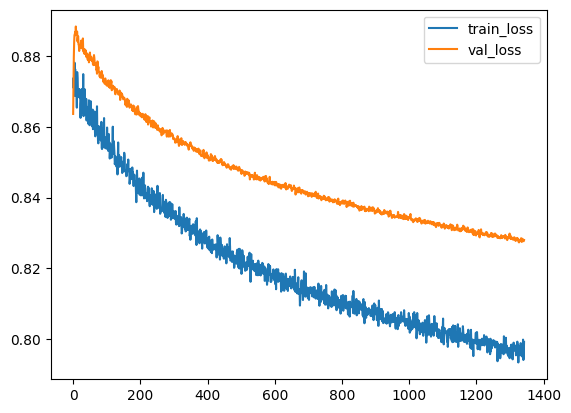

In [15]:
batch_size = 64
epochs = 10000
callbacks = []  # tt.cb.EarlyStopping(patience=50)

# with open('', 'rb') as handle:
#     model = pickle.load(handle)

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)
_ = log.plot()

In [ ]:
# with open(f'model_d{num_durations}_n{"-".join([str(a) for a in num_nodes])}_e{epochs}_lr{lr:.0e}.pkl', 'wb') as handle:
#     pickle.dump(model, handle)

In [ ]:
eval_surv = EvalSurv(
    model.interpolate(20).predict_surv_df(x_test),
    durations_test,
    events_test.astype(bool),
    censor_surv="km",
)

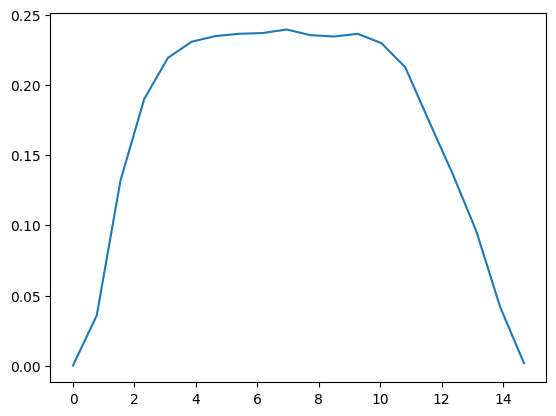

In [ ]:
bs = eval_surv.brier_score(model.duration_index)
plt.plot(bs)

In [ ]:
ibs = eval_surv.integrated_brier_score(model.duration_index)
f"Integrated Brier score: {ibs}"

'Integrated Brier score: 0.17691707621919087'

In [50]:
(
    aggregated_attributions,
    actual_data_attributions,
    survshap_attributions,
    actual_survshap_attributions,
) = compute_attributions(model, x_test, y_test, num_durations, x_raw, all_variables)
aggregated_metric_scores = compute_metrics(
    model, x_test, y_test, actual_data_attributions, used_metrics
)

100%|██████████| 160/160 [01:16<00:00,  2.08it/s]
C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.



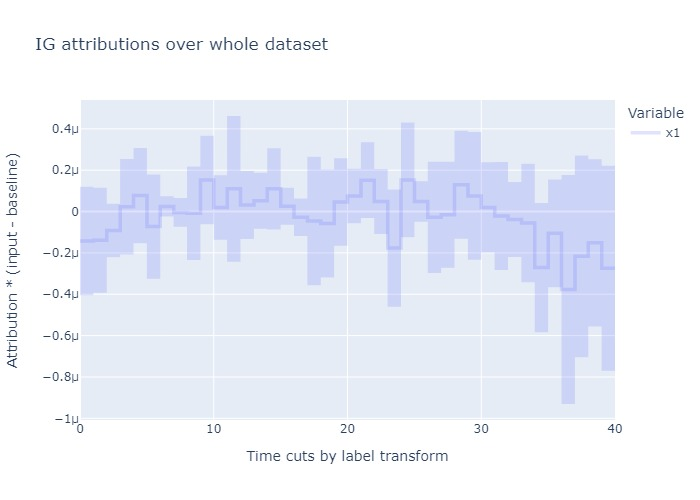

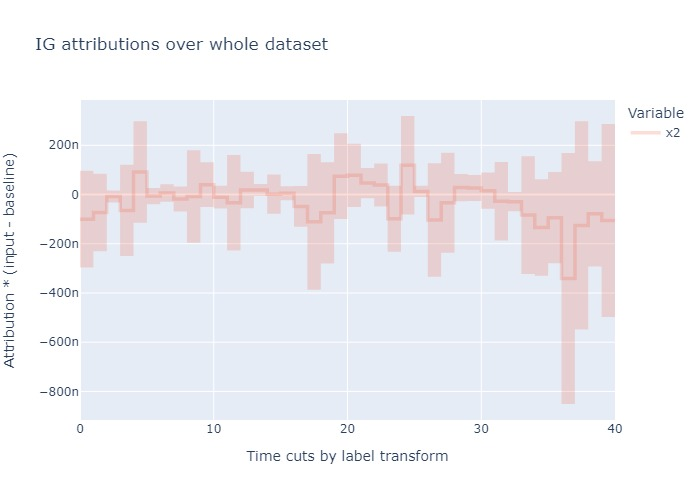

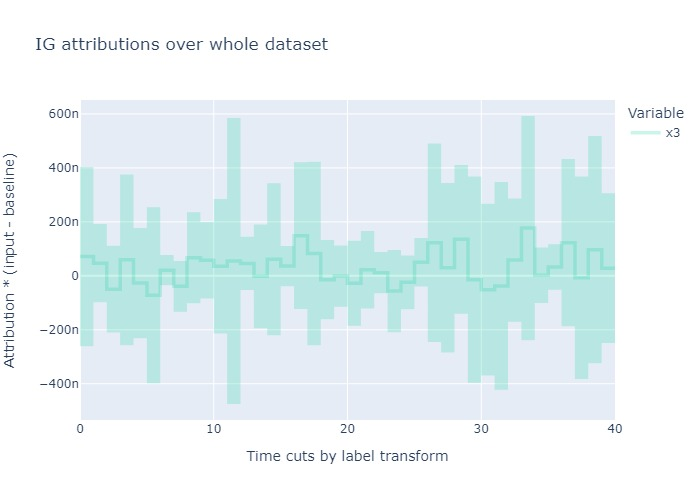

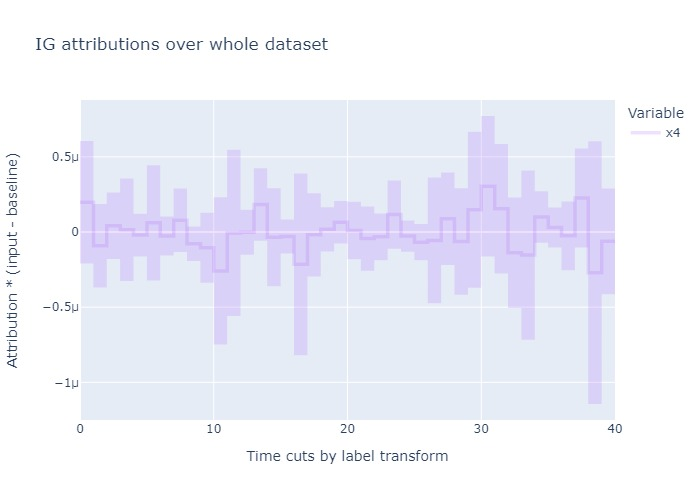

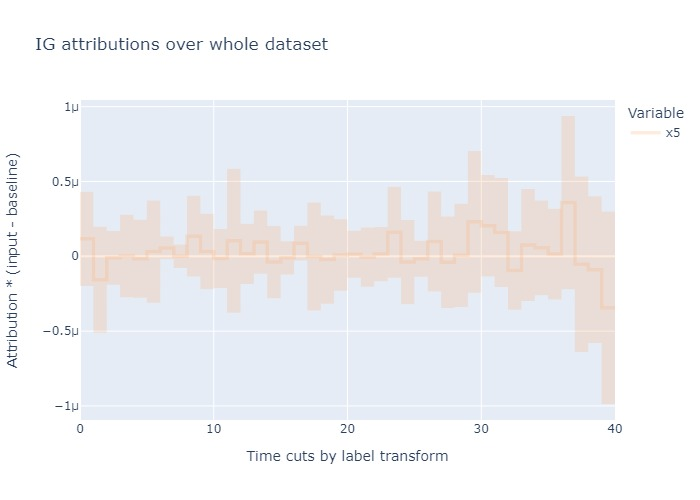

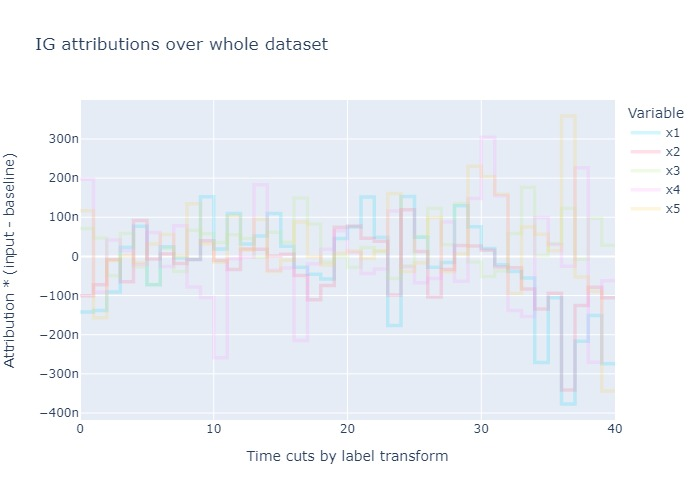

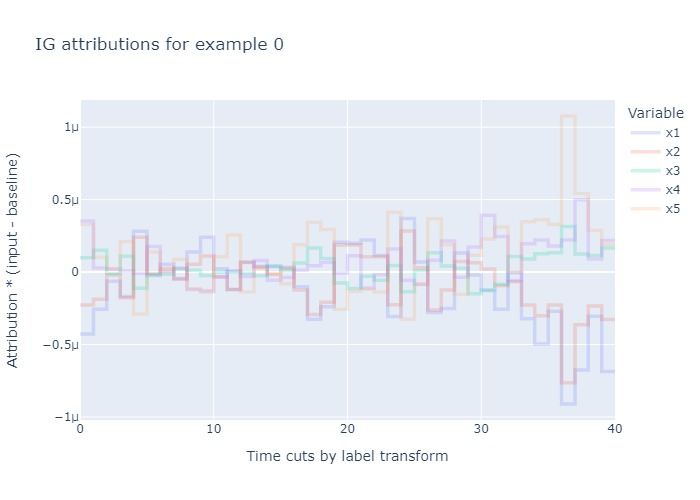

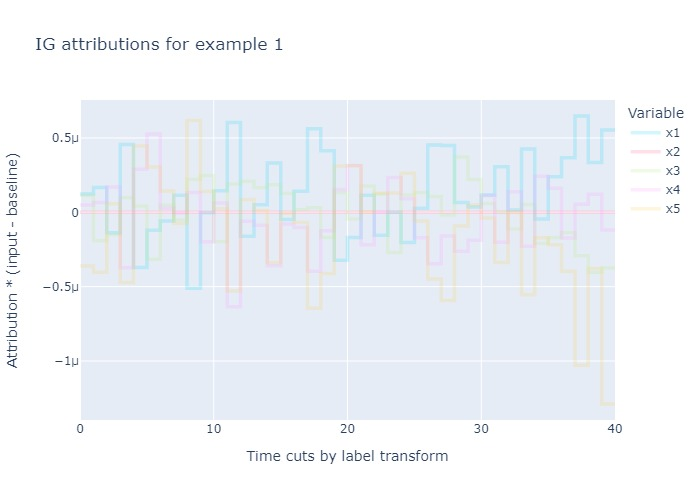

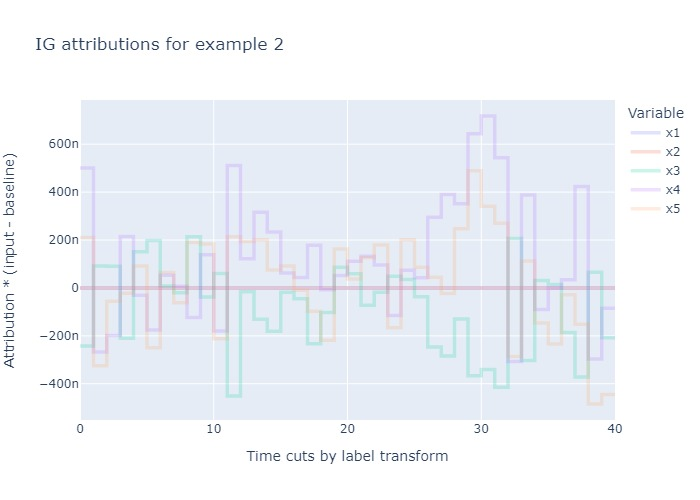

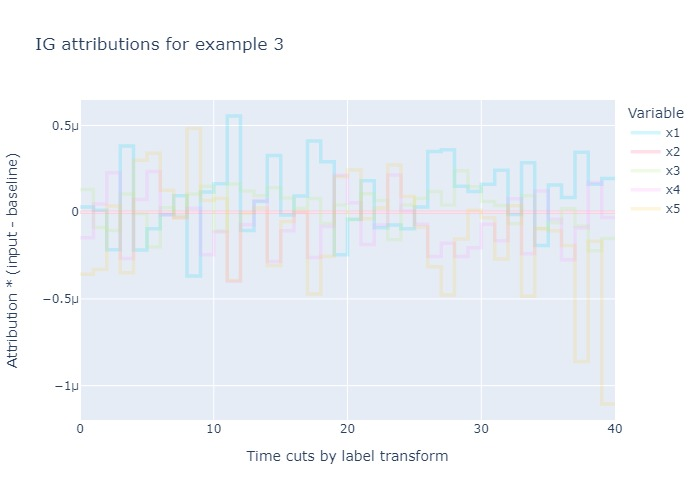

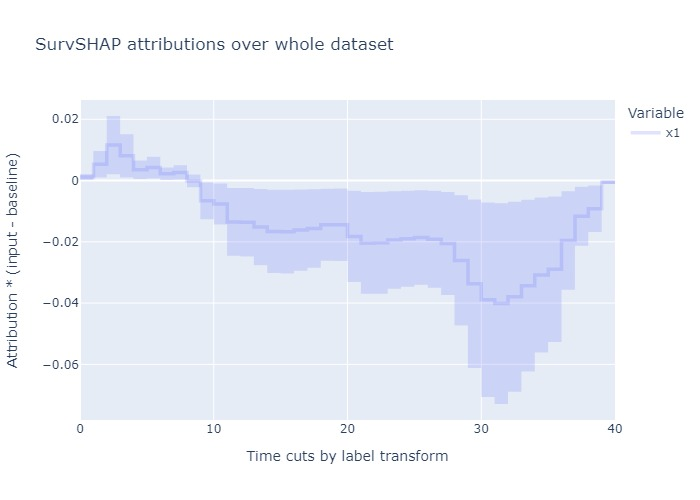

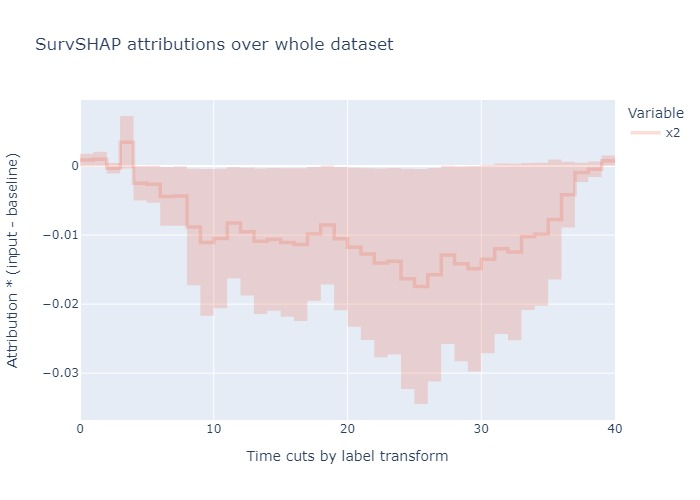

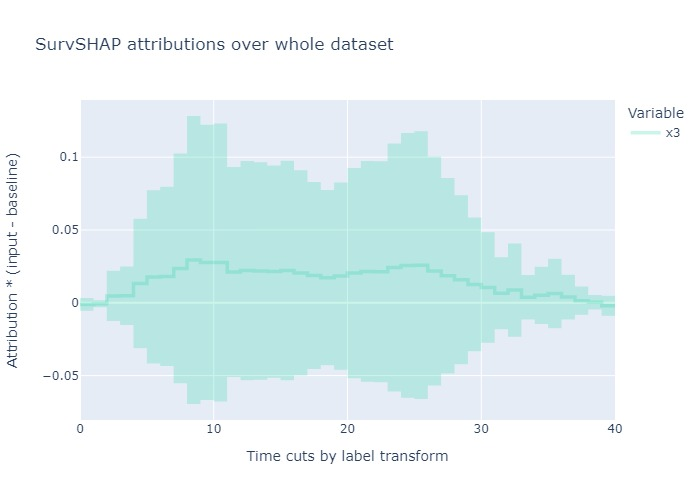

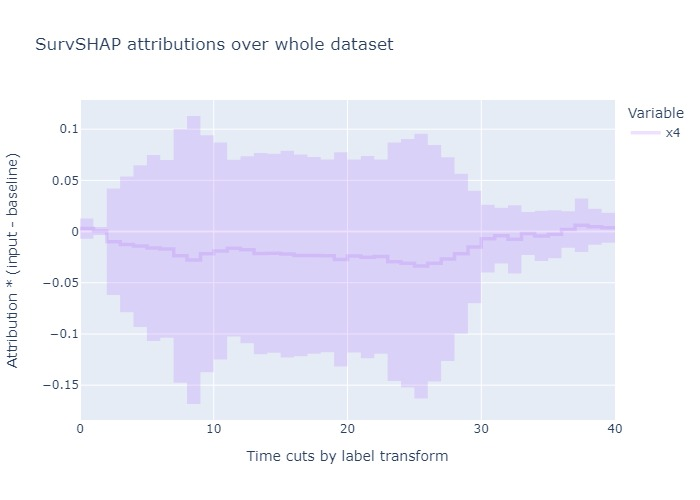

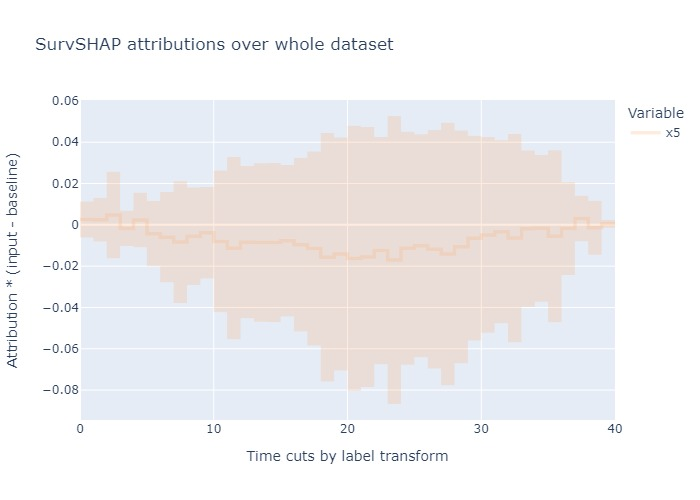

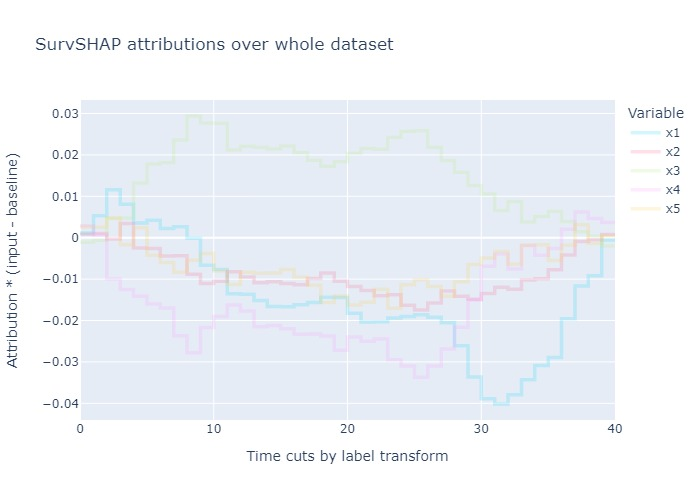

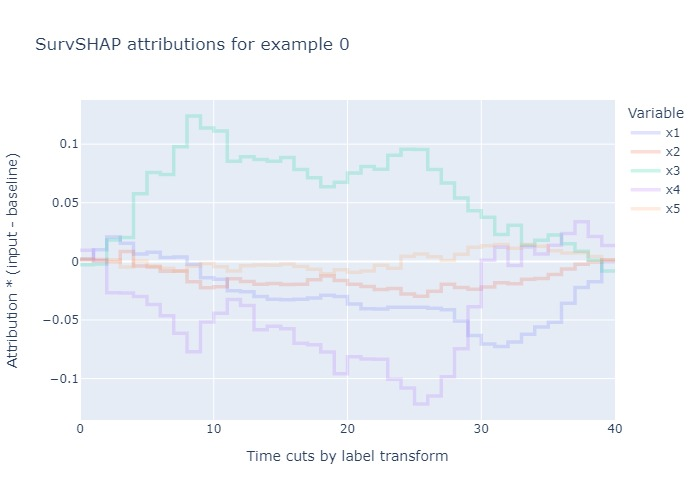

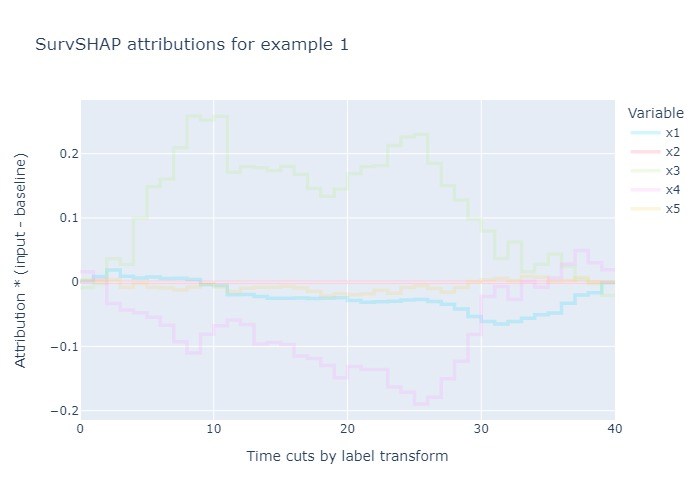

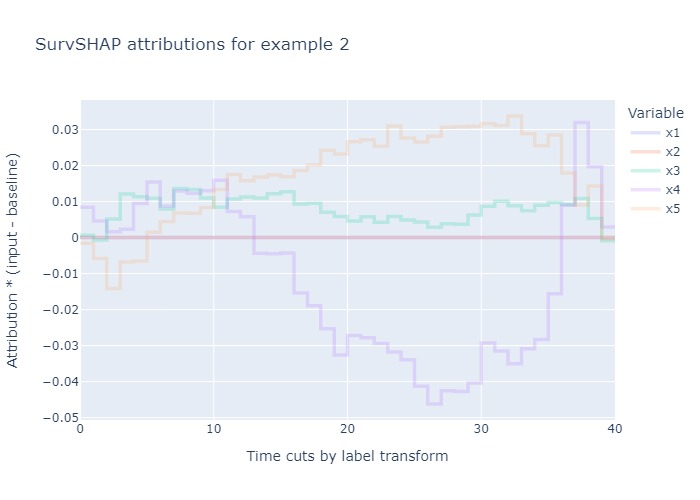

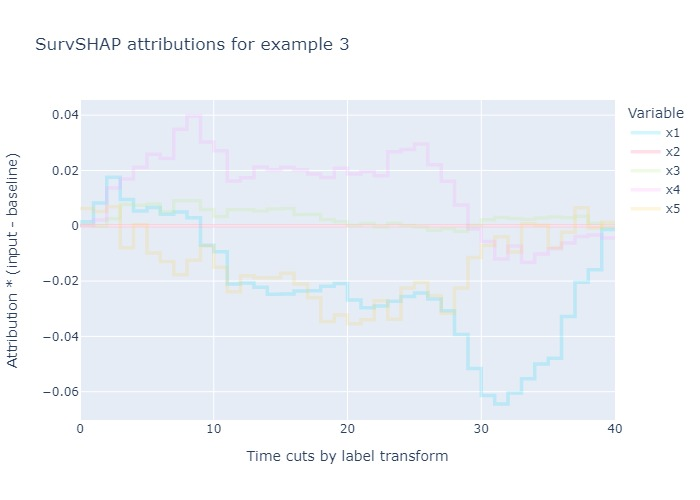

In [51]:
model.eval()
save_dir = f'./our_plots/exp1_d{num_durations}_n{"-".join([str(a) for a in num_nodes])}_e{epochs}_lr{lr:.0e}'
plot_creator = PlotCreator(save_dir=save_dir)

durations = list(range(num_durations + 1))
num_features = x_train.shape[1]

aggregated_attributions_list = [
    aggregated_attributions[:, :, i] for i in range(aggregated_attributions.shape[-1])
]

plot_creator.create_plots(
    aggregated_attributions_list,
    all_variables,
    durations,
    list(range(4)),
    desc="IG attributions",
    save=True,
)

survshap_attributions_list = [
    survshap_attributions[:, :, i] for i in range(survshap_attributions.shape[-1])
]

plot_creator.create_plots(
    survshap_attributions_list,
    all_variables,
    durations,
    list(range(4)),
    desc="SurvSHAP attributions",
    save=True,
)

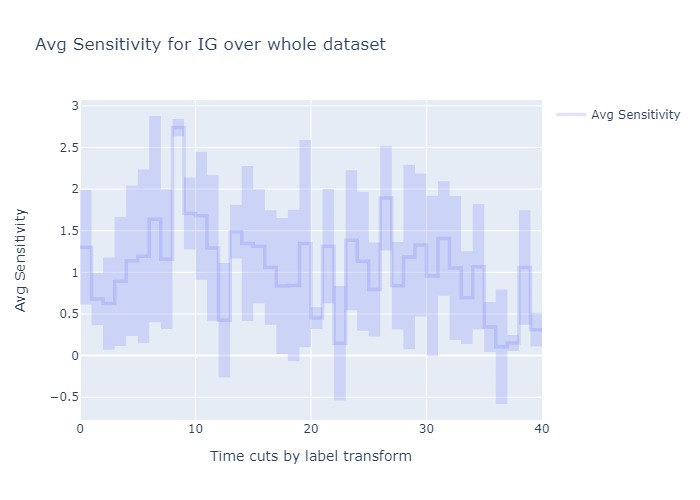

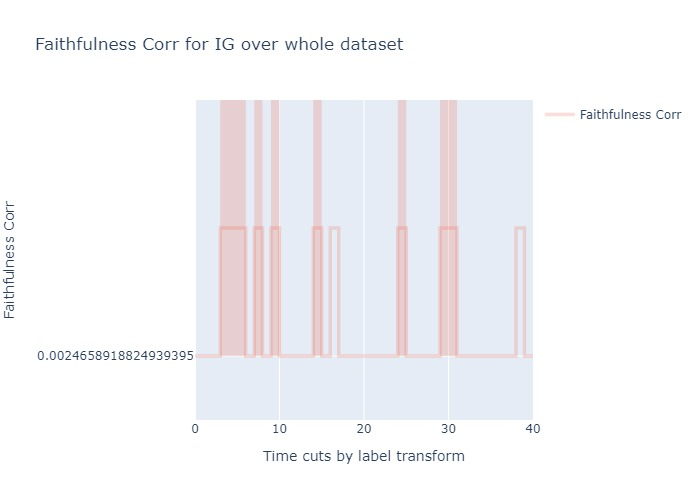

In [52]:
for ams, m_name in zip(aggregated_metric_scores, metrics_names):
    means, stds = PlotCreator.mean_std_per_time(
        np.array(ams.squeeze()), y_test[0], num_durations
    )
    plot_creator.mean_std_figure(
        ams,
        m_name,
        durations,
        y_means=means,
        y_stds=stds,
        desc=f"{m_name} for IG",
        xaxis_title="Time cuts by label transform",
        yaxis_title=m_name,
        legend_title=None,
        save=True,
    )

In [77]:
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle_(
    net, tt.optim.Adam(lr), duration_index=labtrans.cuts, device=DEVICE
)

In [78]:
(
    aggregated_attributions,
    actual_data_attributions,
    survshap_attributions,
    actual_survshap_attributions,
) = compute_attributions(model, x_test, y_test, num_durations, x_raw, all_variables)
aggregated_metric_scores = compute_metrics(
    model, x_test, y_test, actual_data_attributions, used_metrics
)

100%|██████████| 160/160 [01:16<00:00,  2.10it/s]
C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.



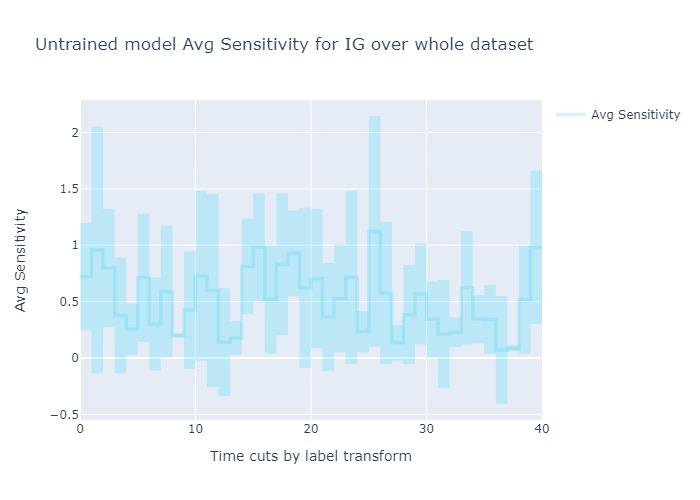

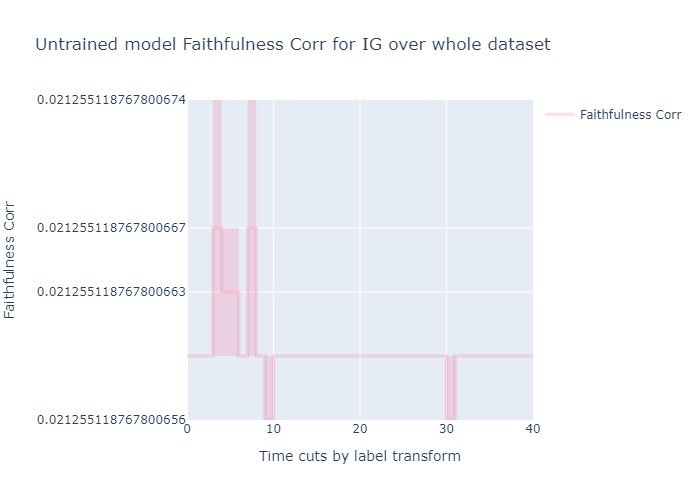

In [79]:
for ams, m_name in zip(aggregated_metric_scores, metrics_names):
    means, stds = PlotCreator.mean_std_per_time(
        np.array(ams.squeeze()), y_test[0], num_durations
    )
    plot_creator.mean_std_figure(
        ams,
        m_name,
        durations,
        y_means=means,
        y_stds=stds,
        desc=f"Untrained model {m_name} for IG",
        xaxis_title="Time cuts by label transform",
        yaxis_title=m_name,
        legend_title=None,
        save=False,
    )

#### Time measurement

In [48]:
y_test_short = (y_test[0][:1], y_test[1][:1])

In [49]:
surv_args = prepare_for_survshap(model, x_test[:1], y_test_short, num_durations, x_raw, all_variables)
ig_args = prepare_for_ig(model, x_test[:1], y_test_short, num_durations, x_raw, all_variables)

In [51]:
%%timeit
compute_survshap(*surv_args)

102 ms ± 7.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
%%timeit
compute_ig(*ig_args)

670 ns ± 16.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


### Experiment 2: Real-world use case: predicting survival of patients with heart failure

#### Preparing data and deep model

In [54]:
df_raw = pd.read_csv("data/exp3_heart_failure_dataset.csv")

df_train, df_val, df_test = train_val_test_split(df_raw)


    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

In [55]:
cols_standardize = [
    "age",
    "creatinine_phosphokinase",
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
]
cols_leave = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]
num_durations = 50

(train, val, test, raw), labtrans = prepare_x_y(
    [df_train, df_val, df_test, df_raw],
    cols_standardize,
    cols_leave,
    num_durations,
    event_column="DEATH_EVENT",
)
x_train, y_train = train
x_val, y_val = val
x_test, y_test = test
x_raw, y_raw = raw
all_variables = [f"x_{i+1}" for i in range(x_raw.shape[1])]

#### Training deep model

In [19]:
in_features = x_train.shape[1]
num_nodes = [5]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.0

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle_(net, tt.optim.Adam(0.00001), duration_index=labtrans.cuts)

batch_size = 64
epochs = 5000
callbacks = []  # [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.5787,	val_loss: 0.5380
1:	[0s / 0s],		train_loss: 0.5772,	val_loss: 0.5339
2:	[0s / 0s],		train_loss: 0.5828,	val_loss: 0.5322
3:	[0s / 0s],		train_loss: 0.5778,	val_loss: 0.5317
4:	[0s / 0s],		train_loss: 0.5779,	val_loss: 0.5316
5:	[0s / 0s],		train_loss: 0.5828,	val_loss: 0.5319
6:	[0s / 0s],		train_loss: 0.5767,	val_loss: 0.5323
7:	[0s / 0s],		train_loss: 0.5812,	val_loss: 0.5326
8:	[0s / 0s],		train_loss: 0.5729,	val_loss: 0.5330
9:	[0s / 0s],		train_loss: 0.5738,	val_loss: 0.5332
10:	[0s / 0s],		train_loss: 0.5796,	val_loss: 0.5333
11:	[0s / 0s],		train_loss: 0.5808,	val_loss: 0.5335
12:	[0s / 0s],		train_loss: 0.5779,	val_loss: 0.5337
13:	[0s / 0s],		train_loss: 0.5740,	val_loss: 0.5338
14:	[0s / 0s],		train_loss: 0.5770,	val_loss: 0.5338
15:	[0s / 0s],		train_loss: 0.5789,	val_loss: 0.5339
16:	[0s / 0s],		train_loss: 0.5781,	val_loss: 0.5339
17:	[0s / 0s],		train_loss: 0.5753,	val_loss: 0.5339
18:	[0s / 0s],		train_loss: 0.5835,	val_loss: 0.5339
19:

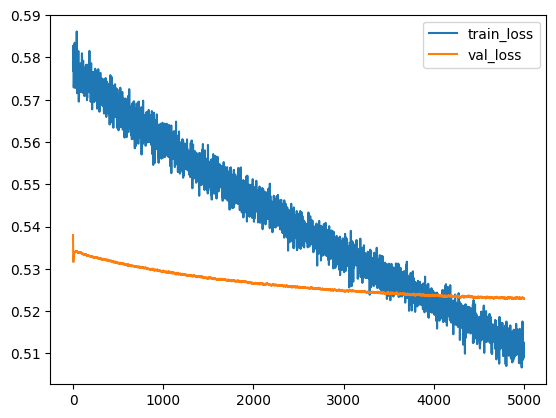

In [20]:
_ = log.plot()


In [21]:
eval_surv = EvalSurv(
    model.predict_surv_df(x_train),
    y_train[0],
    y_train[1].astype(bool),
    censor_surv="km",
)

/home/kuba/.local/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



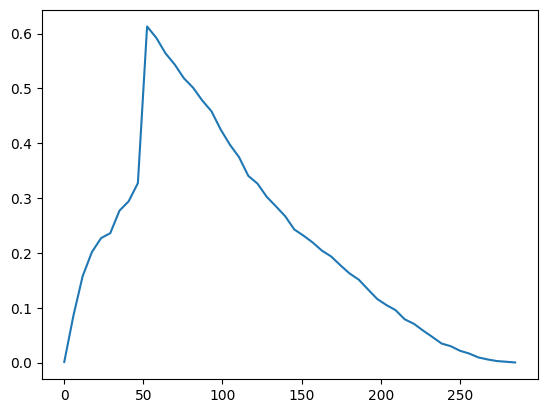

In [22]:
bs = eval_surv.brier_score(model.duration_index)
plt.plot(bs)

In [23]:
ibs = eval_surv.integrated_brier_score(model.duration_index)
f"Integrated Brier score: {ibs}"

'Integrated Brier score: 0.2288586966723037'

In [24]:
(
    aggregated_attributions,
    actual_data_attributions,
    survshap_attributions,
    actual_survshap_attributions,
) = compute_attributions(model, x_test, y_test, num_durations, x_raw, all_variables)

100%|██████████| 48/48 [10:38<00:00, 13.31s/it]


In [25]:
aggregated_metric_scores = compute_metrics(
    model, x_test, y_test, actual_data_attributions, used_metrics
)

/home/kuba/.local/lib/python3.10/site-packages/quantus/helpers/warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.



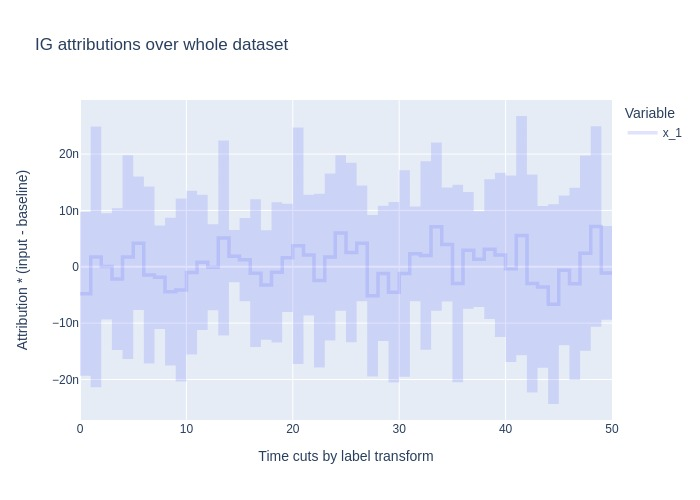

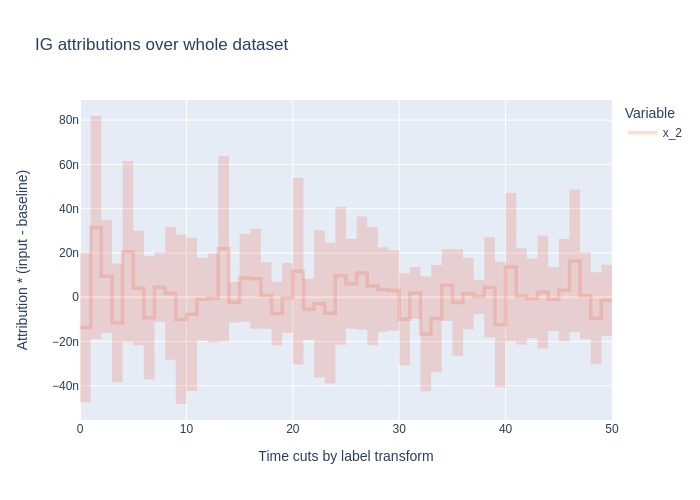

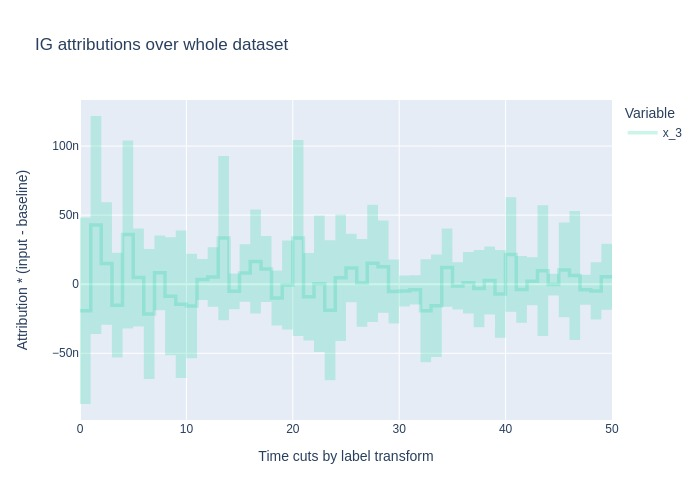

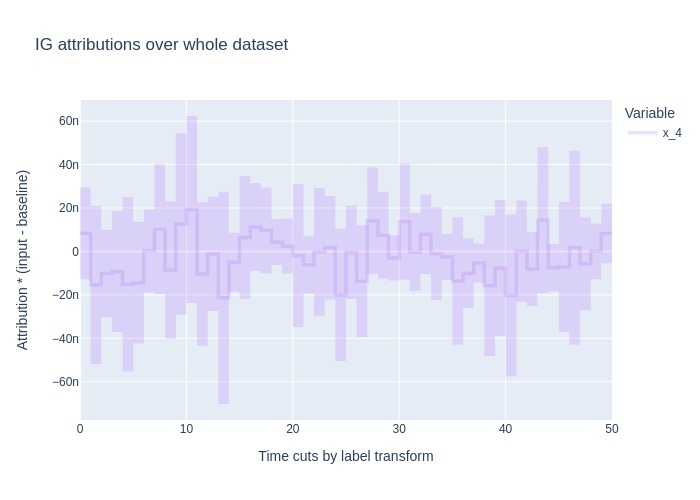

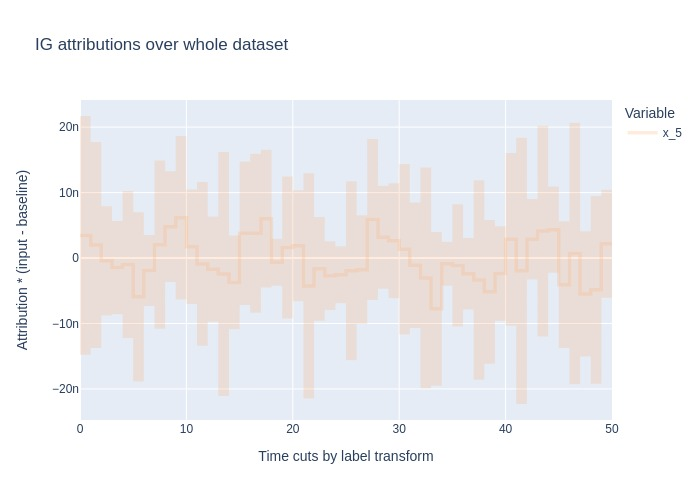

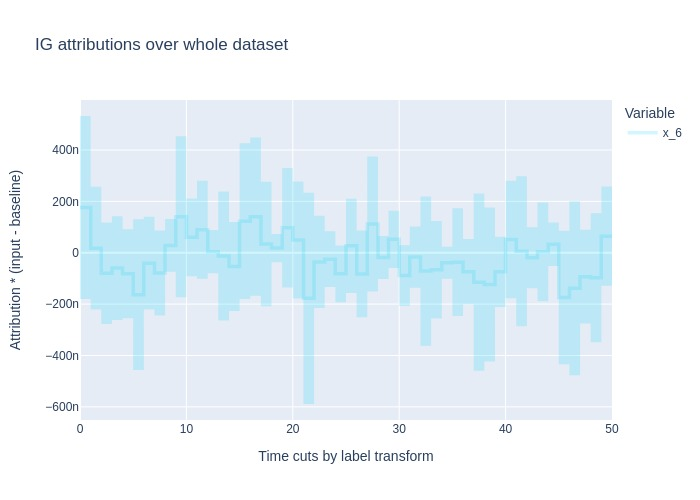

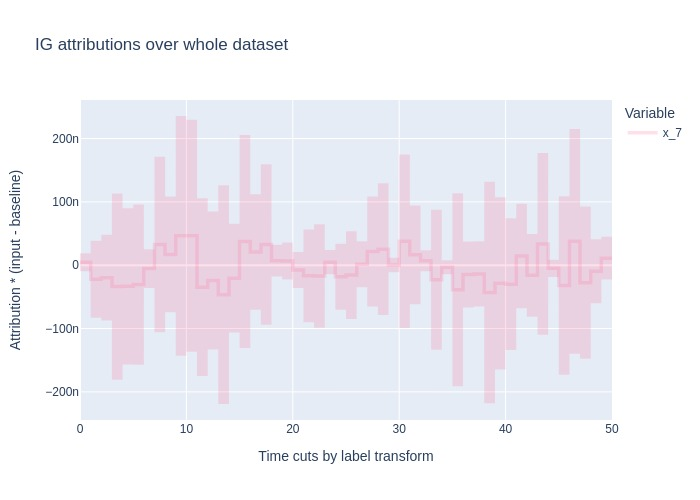

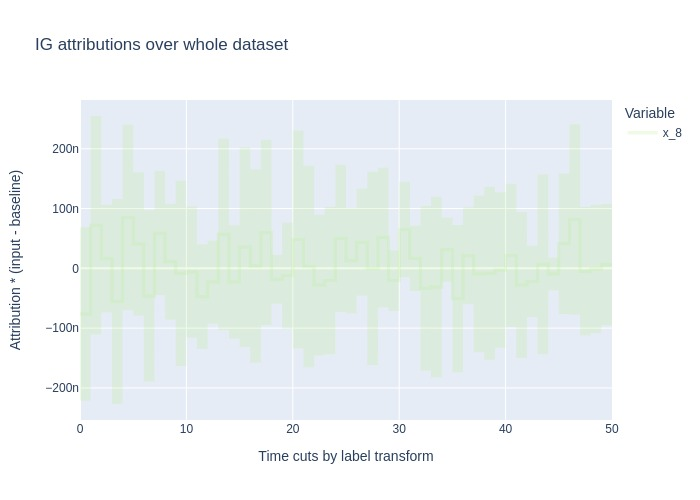

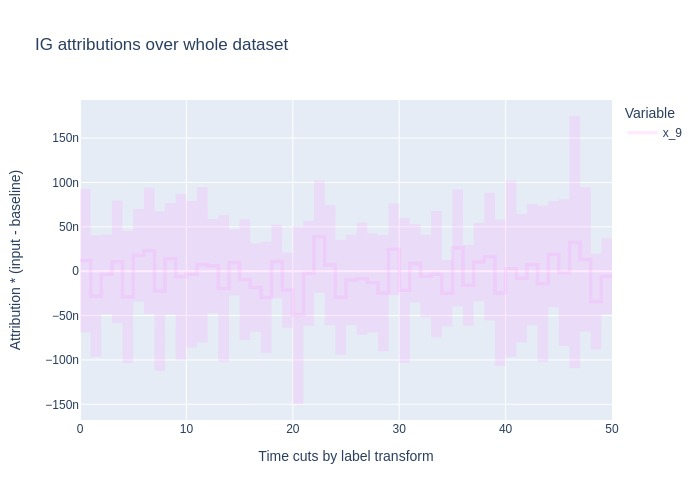

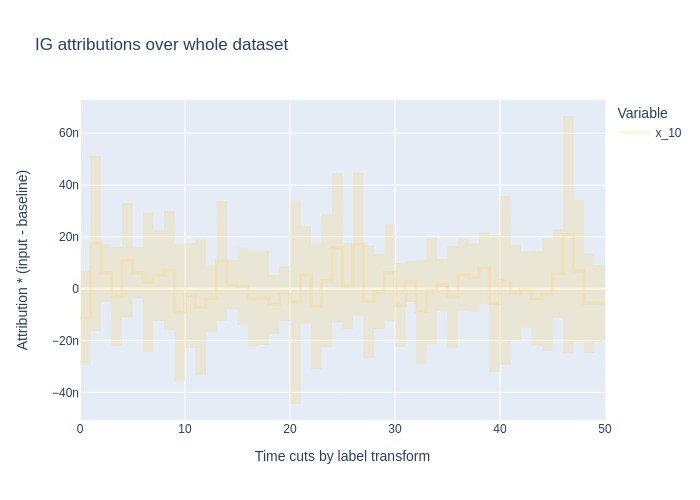

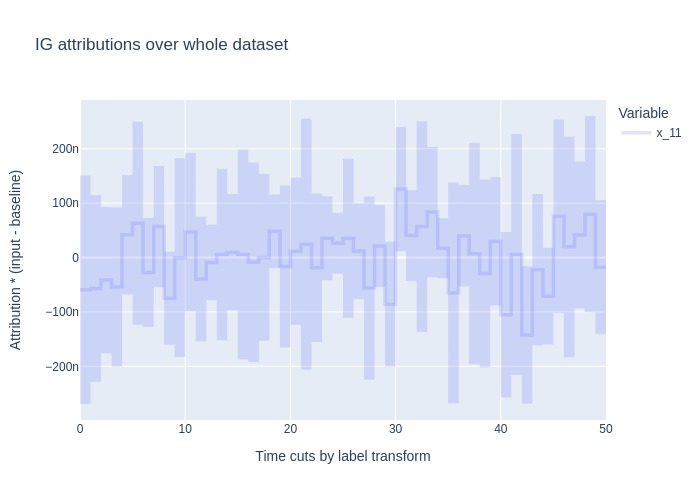

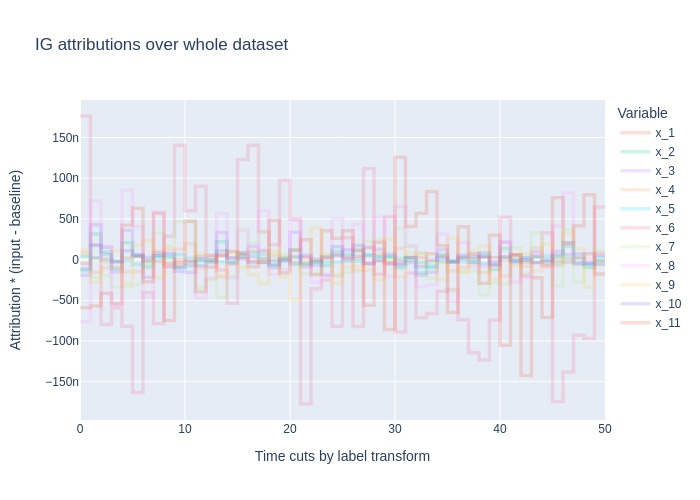

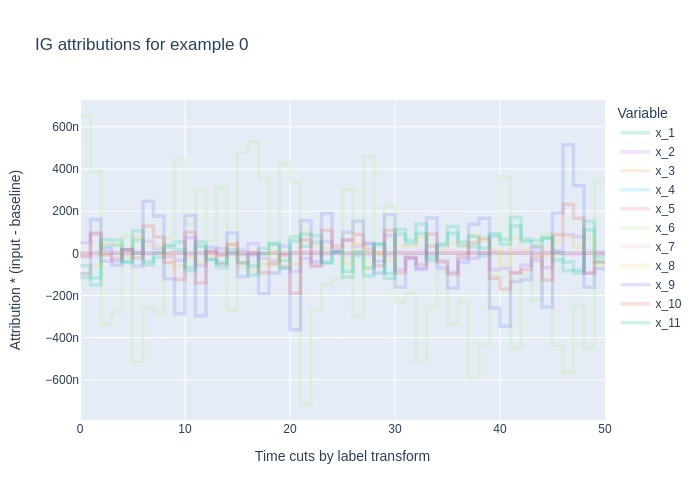

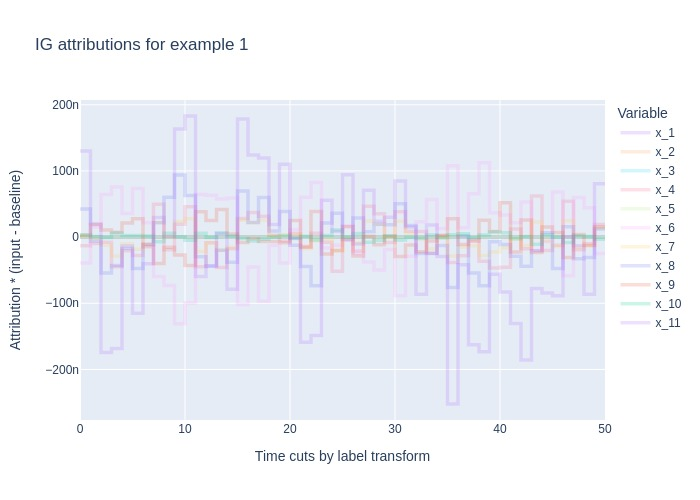

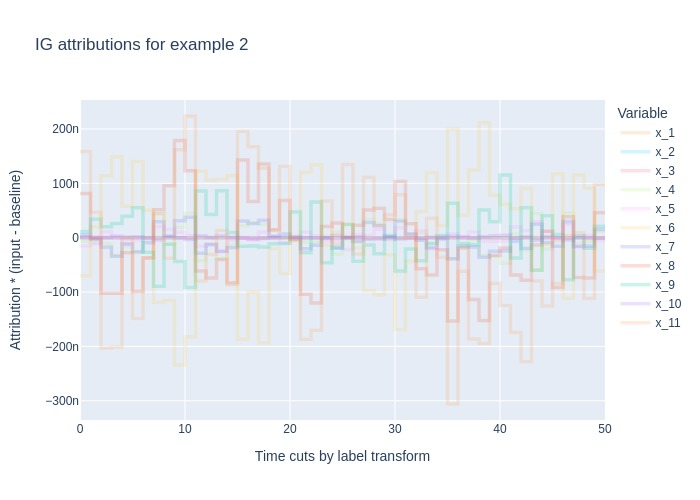

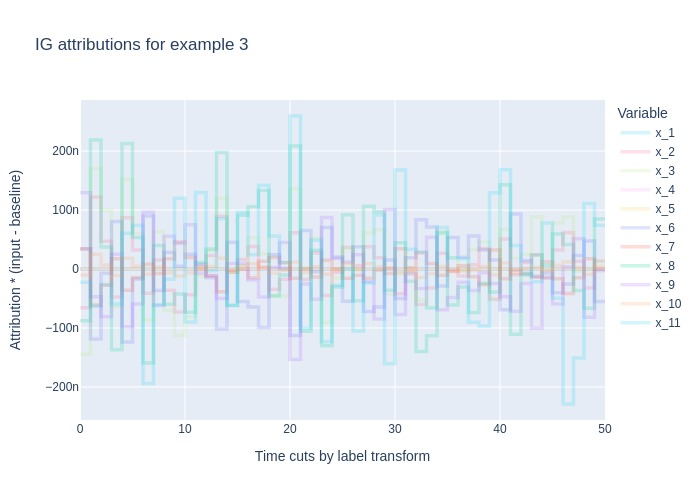

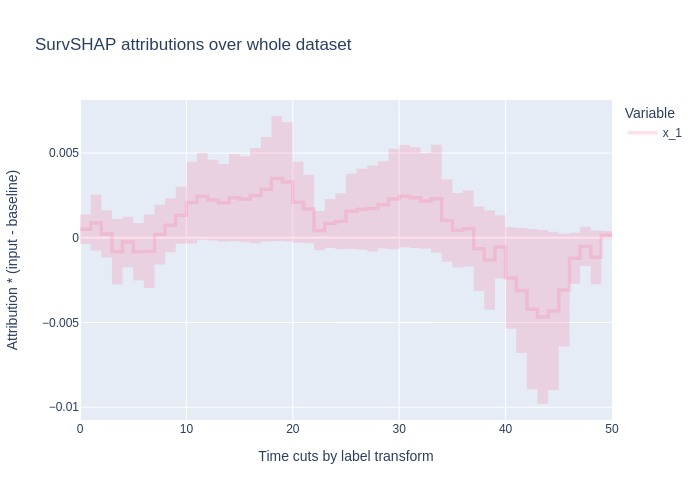

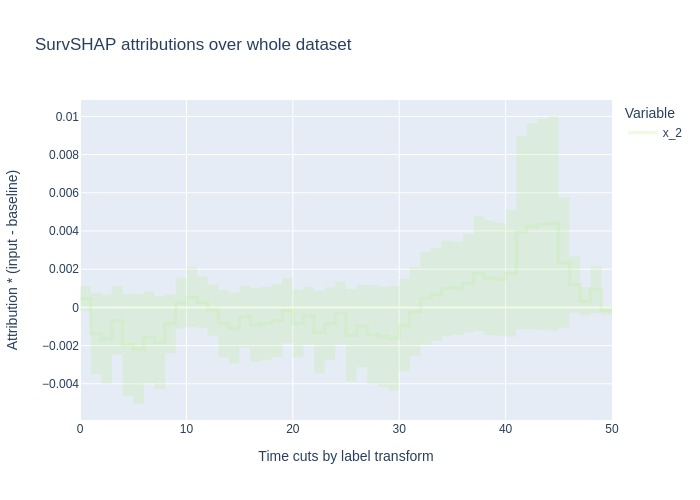

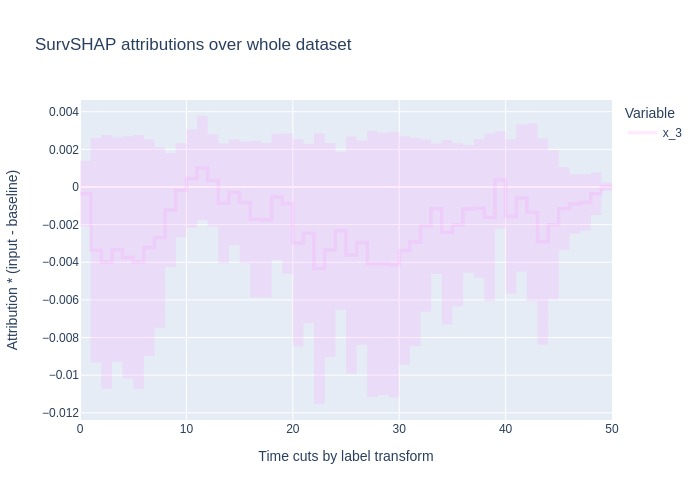

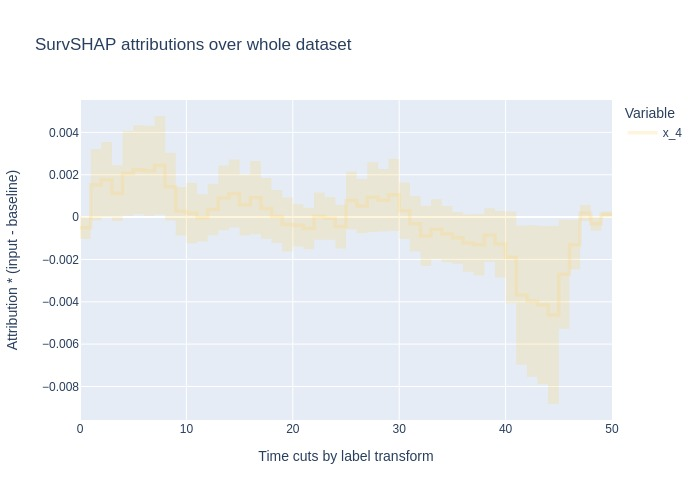

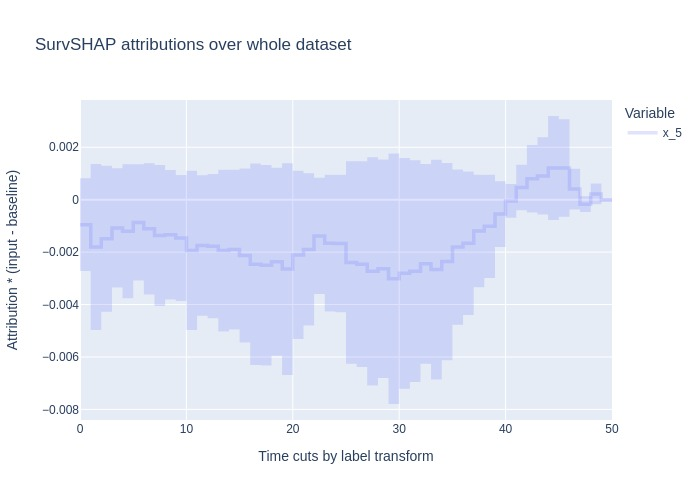

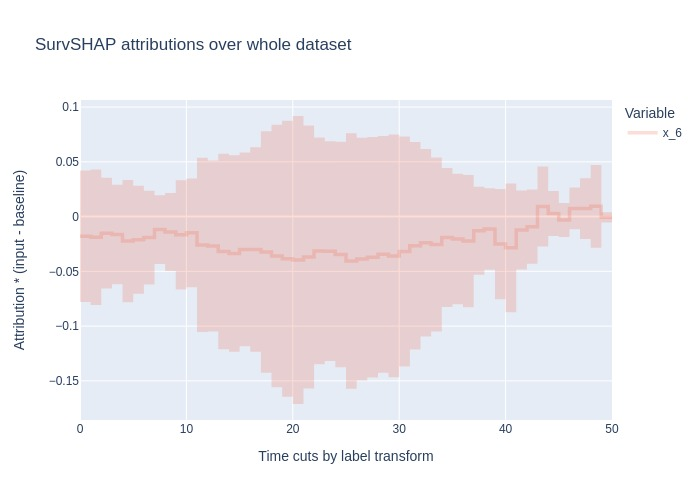

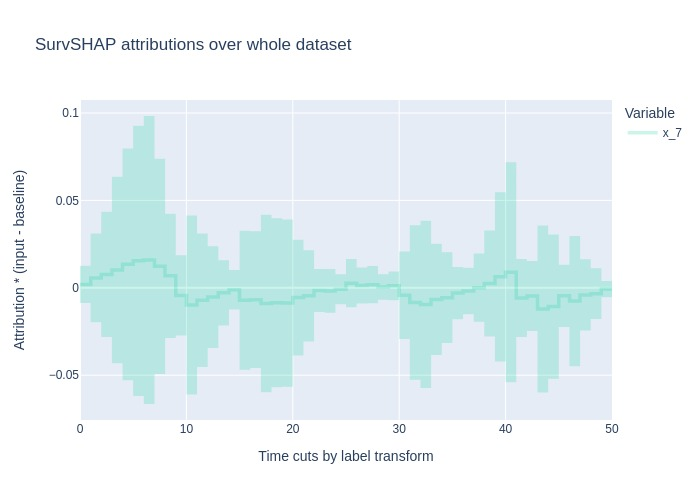

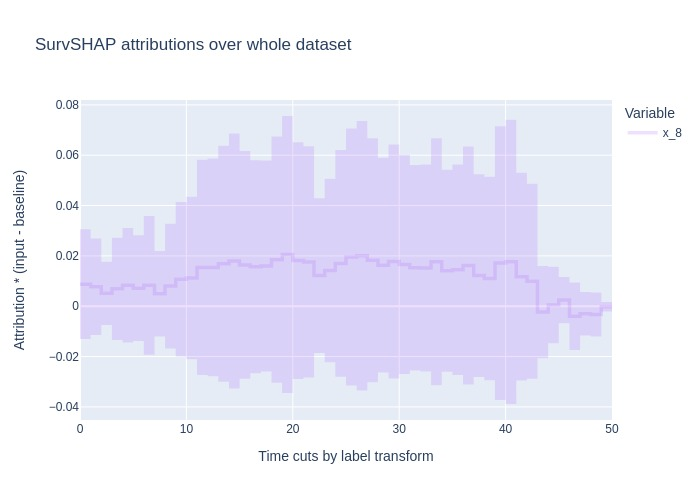

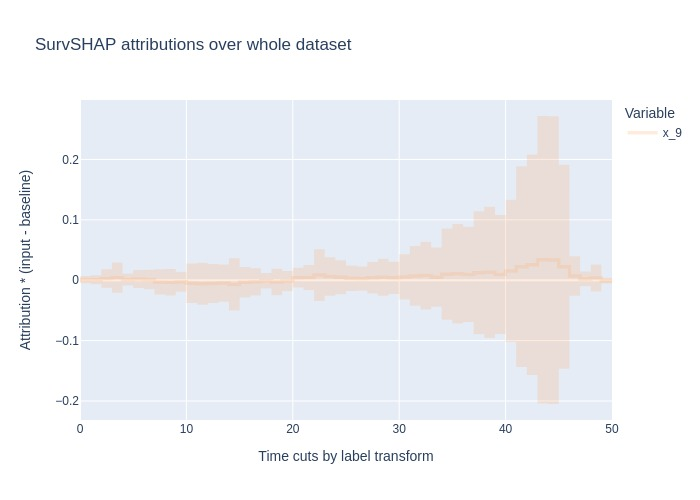

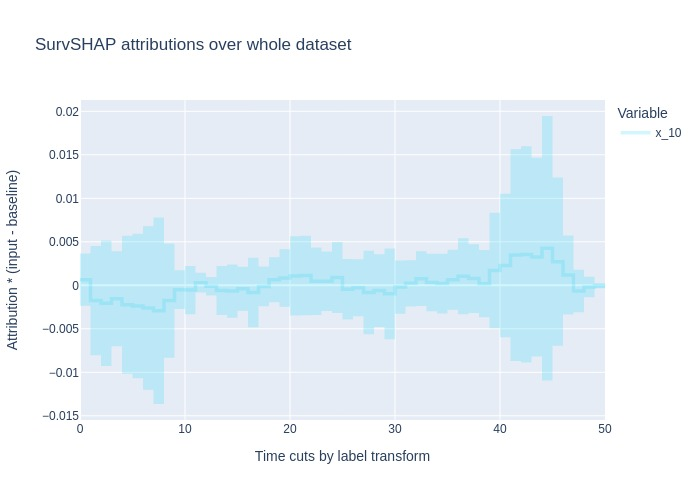

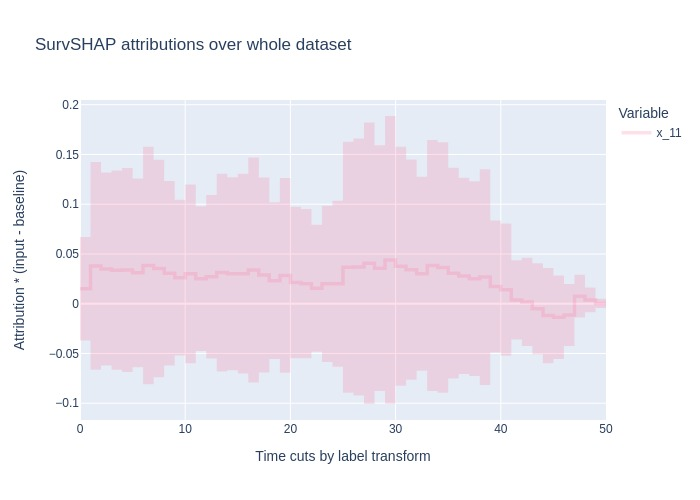

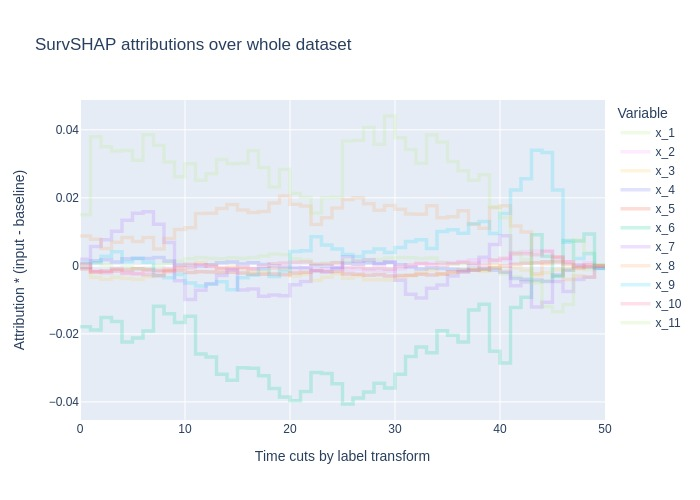

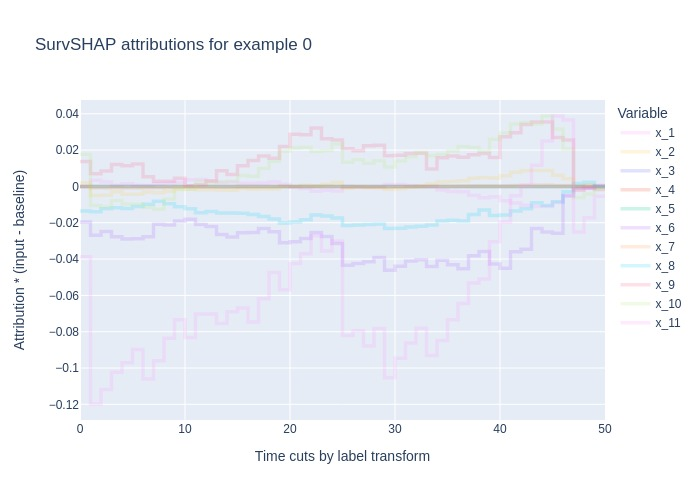

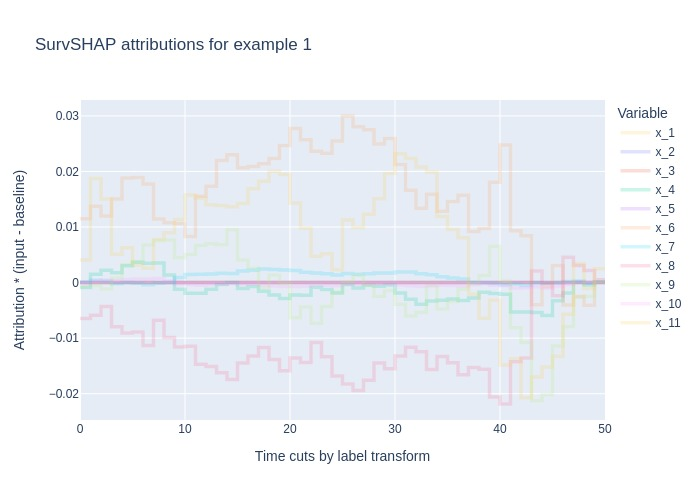

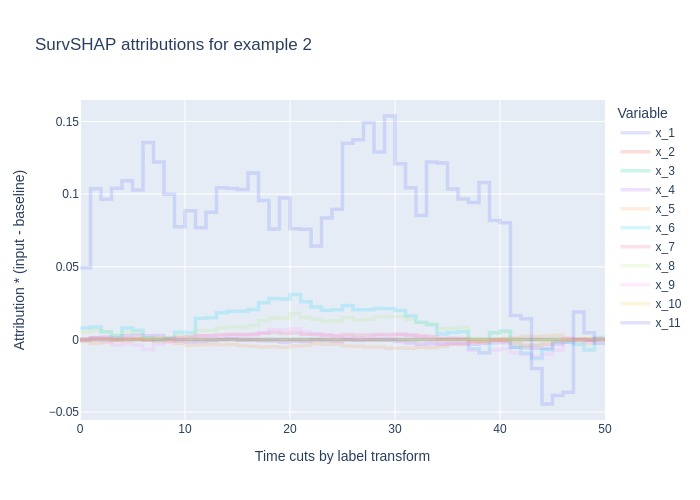

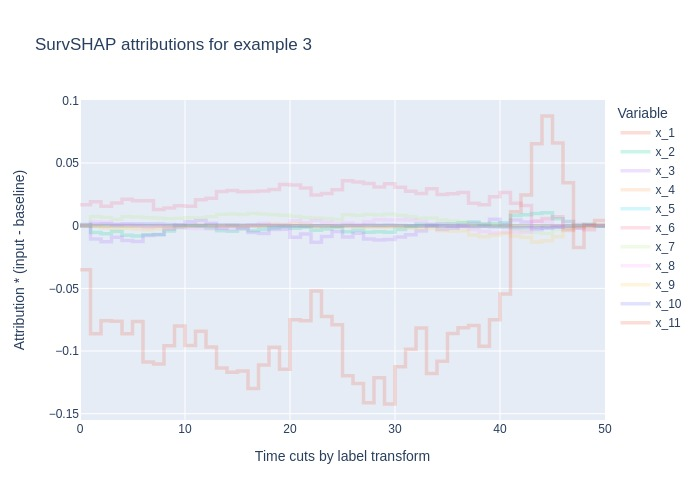

In [27]:
model.net.eval()
save_dir = f'./our_plots/exp2'
plot_creator = PlotCreator(save_dir=save_dir)

durations = list(range(num_durations + 1))
num_features = x_train.shape[1]

aggregated_attributions_list = [
    aggregated_attributions[:, :, i] for i in range(aggregated_attributions.shape[-1])
]

plot_creator.create_plots(
    aggregated_attributions_list,
    all_variables,
    durations,
    list(range(4)),
    desc="IG attributions",
    save=True,
)

survshap_attributions_list = [
    survshap_attributions[:, :, i] for i in range(survshap_attributions.shape[-1])
]

plot_creator.create_plots(
    survshap_attributions_list,
    all_variables,
    durations,
    list(range(4)),
    desc="SurvSHAP attributions",
    save=True,
)

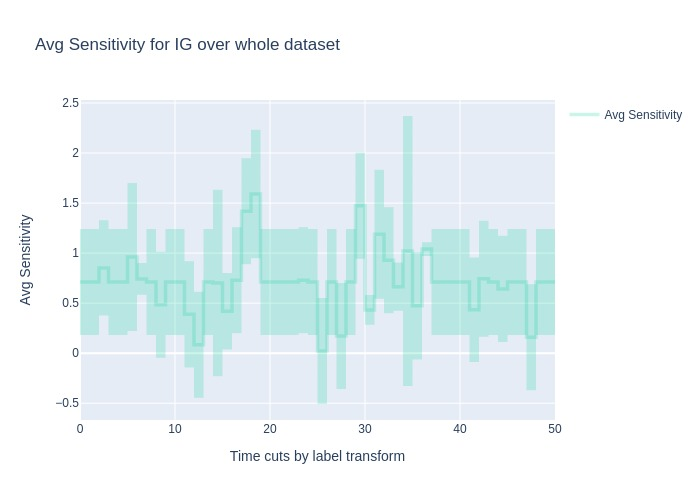

In [28]:
for ams, m_name in zip(aggregated_metric_scores, metrics_names):
    means, stds = PlotCreator.mean_std_per_time(
        np.array(ams.squeeze()), y_test[0], num_durations
    )
    plot_creator.mean_std_figure(
        ams,
        m_name,
        durations,
        y_means=means,
        y_stds=stds,
        desc=f"{m_name} for IG",
        xaxis_title="Time cuts by label transform",
        yaxis_title=m_name,
        legend_title=None,
        save=True,
    )

In [59]:
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle_(
    net, tt.optim.Adam(0.00001), duration_index=labtrans.cuts, device=DEVICE
)

In [61]:
(
    aggregated_attributions,
    actual_data_attributions,
    survshap_attributions,
    actual_survshap_attributions,
) = compute_attributions(model, x_test, y_test, num_durations, x_raw, all_variables)

In [33]:
aggregated_metric_scores = compute_metrics(
    model, x_test, y_test, actual_data_attributions, used_metrics
)

/home/kuba/.local/lib/python3.10/site-packages/quantus/helpers/warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.



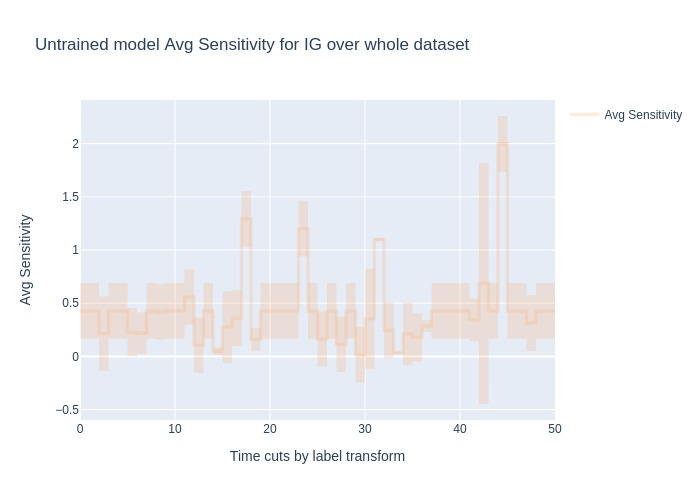

In [34]:
for ams, m_name in zip(aggregated_metric_scores, metrics_names):
    means, stds = PlotCreator.mean_std_per_time(
        np.array(ams.squeeze()), y_test[0], num_durations
    )
    plot_creator.mean_std_figure(
        ams,
        m_name,
        durations,
        y_means=means,
        y_stds=stds,
        desc=f"Untrained model {m_name} for IG",
        xaxis_title="Time cuts by label transform",
        yaxis_title=m_name,
        legend_title=None,
        save=False,
    )

#### Time measurement

In [62]:
y_test_short = (y_test[0][:1], y_test[1][:1])

In [63]:
surv_args = prepare_for_survshap(model, x_test[:1], y_test_short, num_durations, x_raw, all_variables)
ig_args = prepare_for_ig(model, x_test[:1], y_test_short, num_durations, x_raw, all_variables)

In [64]:
%%timeit
compute_survshap(*surv_args)

2.71 s ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%%timeit
compute_ig(*ig_args)

680 ns ± 15.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
